# Numerical Approaches to General Equilibrium and Prices

In [1]:
import numpy as np
from scipy import linalg as la
from scipy import stats as st
from scipy import optimize as opt
from matplotlib import pyplot as plt
from time import time

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [8, 5]

## Solving for the General Equilibrium when Explicit Prices are Involved

Consider the following problem

\begin{align*}
    V(A) = \max_{C, A'} &\; \frac{C^{1-\gamma}}{1-\gamma} + \beta\ V(A') \\
    \text{s.t.} &\;
        \begin{cases}
            C + A' \leq Y + (1 + r) A \\
            A' \geq \underline{A}
        \end{cases}
\end{align*}

where $Y$ is an exogenously given deterministic endowment. Households in this context can be represented by a representative agent. This problem is not particularly interesting, from a numerical point of view. The first order conditions associated to the problem are

\begin{equation*}
    \begin{cases}
        C_t^{-\gamma} = C_{t+1}^{-\gamma} \beta\ (1 + r) \\
        C_t + A_{t+1} = Y + (1 + r) A_t
    \end{cases}
\end{equation*}

The market clearing condition imposes that $A_t^* = 0$. This means that the representative household must hold a zero net financial position at all times. In other words, the representative household cannot borrow, nor save, against non-existing aliens. Therefore, the equilibrium values for the endogenous variables are

\begin{equation*}
    \begin{cases}
        r^* = 1/\beta - 1 \\
        C_t^* = Y  & \forall\ t \\
        A_t^* = 0  & \forall\ t
    \end{cases}
\end{equation*}

However, we can use this model to explain how we can numerically solve for prices. Suppose that we could not determine $r^*$ analytically. Solving for the policy functions with either VFI or PFI requires setting a value for $r$. How can we do this?

It turns out, we can exploit the properties of the net excess demand to our advantage. Start from the Bellman equation and obtain the policy function for asset holdings $A'(A)$ given any numeric value for $r$. The market clearing condition imposes that $A'(0) = 0$. Therefore, we can check whether this condition holds at the given level of $r$ we have set. If not, the we know that the net excess demand is a continuous and monotone decreasing function of the price for a very wide class of models. Let the net excess demand be $Z(r)$. Suppose we find two values $\underline{r} < \overline{r}$ such that $Z(\underline{r}) > 0$ and $Z(\overline{r}) < 0$. By the Intermediate Value Theorem, we know that there exists $r^*$ such that $Z(r^*) = 0$.

We can thus rely on the following algorithm:

1. At iteration $j$, formulate a guess $r^{(j)}$
1. Solve for the policy functions given the value $r^{(j)}$
1. Construct the net excess demand $Z(r)$
1. Evaluate $Z(r^{(j)})$:
   - If $Z(r^{(j)}) > 0$, repeat 2-4 using $r^{(j+1)} < r^{(j)}$
   - If $Z(r^{(j)}) < 0$, repeat 2-4 using $r^{(j+1)} > r^{(j)}$
   - If $Z(r^{(j)}) = 0$, stop the algorithm and set $r^* = r^{(j)}$

Because of the properties of $Z(r)$, that is continuity and monotonicity, and leveraging the Intermediate Value Theorem, the algorithm is proven to converge. Luckily, we do not have to write all of the algorithm by ourselves.
The module [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding) contains many routines that find the root of functions. In our example, we have a univariate function $Z : \mathbb{R} \to \mathbb{R}$, so the best options are

- [`scipy.optimize.bisect`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html#scipy.optimize.bisect)
- [`scipy.optimize.brentq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq)
- [`scipy.optimize.ridder`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.ridder.html#scipy.optimize.ridder)
- [`scipy.optimize.toms748`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.toms748.html#scipy.optimize.toms748)

These routines are specialized on univariate functions and are guaranteed to converge with varying convergence speeds.

Therefore, we now proceed to do all of this.

First, as usual, we calibrate the model setting some paramter values and creating the grid for the state variable.

In [2]:
beta = 0.97
gamma = 1.5
y = 1.0
n = 100 + 1
a = np.linspace(-5, 5, num=n)  # ensuring there's a value that is exactly zero, see later

Next, and just because we can, let us find the analytical solution $r^*$ of the model. This is helpful to guide our choice of $\underline{r}$ and $\overline{r}$. To be clear, here we are "cheating," because normally we have no way to find the values $\underline{r}$ and $\overline{r}$ if not by trial-and-error.

In [3]:
rSol = 1 / beta - 1
print('r* = {:.5f}'.format(rSol))

r* = 0.03093


Now we create the representative agent using a `class`. Creating the instance of the agent parametrizes the problem. Calling the agent causes VFI to kick in, returning the policy function.

In [4]:
class Agent:
    
    def __init__(self, beta, gamma, a, y):
        self.beta = beta
        self.gamma = gamma
        self.y = y
        self.a = a
        
    def __call__(self, r, tol=1e-6):
        n = self.a.size
        v = np.zeros((n,1))
        v_new = np.zeros((n,1))
        dr = np.zeros((n,1), dtype=int)
        criterion = 1
        n_iter = 0
        t0 = time()
        while criterion > tol:
            n_iter += 1
            for i in range(n):
                c = self.y + self.a[i] * (1 + r) - self.a
                c[c<=0] = np.nan
                u = c ** (1 - self.gamma) / (1 - self.gamma)
                obj = u + self.beta * v[:, -1]
                v_new[i] = np.nanmax( obj )
                dr[i] = obj.tolist().index(v_new[i])
            v = np.block([v, v_new])
            criterion = np.max(np.abs(v[:, -1] - v[:, -2]))
        t1 = time()
        a_opt = self.a[dr]
        self.v = v
        print('VFI took {0:.3f} seconds, {1} iterations (r={2:.3f}%).'.format(t1-t0, n_iter, r*100))
        # c_opt = self.y + self.a * (1 + r) - a_opt
        return a_opt

In [5]:
rLo, rHi = np.array([0.75, 1.25]) * rSol
ra = Agent(beta, gamma, a, y)

Now, we need to define the net excess demand $Z(r)$. Given the policy function above, we know that $Z(r) = A'(0)$. That is, an agent with currently no savings nor borrowings that has $A'(0) > 0$ is asking to save, and is therefore willing to give up "cash" (formally, consumption good) in exchange for the financial asset. However, nobody is there in the economy to provide the asset. Similarly, if $A'(0) < 0$, the agent is asking to borrow, because they are willing to give up assets in exchange for "cash" (formally, consumption good), but nobody is there in the economy to buy the asset.

Therefore, we need to locate where $A = 0$ on the grid for the state variable and we need to access $A'(A)$ at that location.

In [6]:
where_a_is_zero = a.tolist().index(0)  # locate where A = 0
z = lambda x: ra(x)[where_a_is_zero]   # define Z(r) = A'(0)
rStar, diagnostics = opt.ridder(z, rLo, rHi, full_output=True)  # run the root-finding algorithm, obtain extra info

VFI took 4.660 seconds, 480 iterations (r=2.320%).
VFI took 4.946 seconds, 478 iterations (r=3.866%).
VFI took 4.777 seconds, 481 iterations (r=3.093%).
VFI took 4.693 seconds, 481 iterations (r=3.093%).


In [7]:
diagnostics

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 1
           root: 0.030927835051546504

As we can see from this `diagnostics` object, the root-finding routine has established convergence to a value. Let us compare this value to the analytical solution.

In [8]:
print('Analytical solution: r = {:.50f}'.format(rSol))
print(' Numerical solution: r = {:.50f}'.format(rStar))

Analytical solution: r = 0.03092783505154650391943960130447521805763244628906
 Numerical solution: r = 0.03092783505154650391943960130447521805763244628906


Indeed, our numerical algorithm nailed the solution to a very high precision.

## From Policy Functions to Endogenous Ergodic Distributions

Let us now consider a slight, but important variation to the problem above. Assume that the economy is populated by a unit-measure mass of agents, where each agent is atomistic and solves the following problem.

\begin{align*}
    V(A, Y) = \max_{C, A'} &\; \frac{C^{1-\gamma}}{1-\gamma} + \beta\ \mathbf{E} \left( V(A', Y') \middle| A, Y \right) \\
    \text{s.t.} &\;
        \begin{cases}
            C + A' \leq Y + (1 + r) A \\
            A' \geq \underline{A} \\
            P(Y'|Y) = \Pi
        \end{cases}
\end{align*}

In this variation, we assume that $Y_t$ is idiosyncratic for each household. In other words, we are imposing idiosyncratic uncertainty, but no aggregate uncertainty. This problem is now interesting, because it introduces an important step in our price-solving algorithm. While the first-order conditions for each agent are similar to those we found above, the market clearing condition (for an ergodic recursive equilibrium) is quite different. It reads

\begin{equation*}
    \int_A \int_Y \lambda(A, Y)\ A'(A, Y)\ \text{d}Y\ \text{d}A = 0
\end{equation*}

In words, this condition is saying that there will be a mass of agents who borrow and a mass of agents who save. The total amount of savings must equal the total amount of borrowings. This means that the equilibrium rate $r^*$ now depends on the endogenous distribution of agents $\lambda(A, Y)$. First, where does this distribution come from? It arises from the combination of the endogenous policy functions $A'(A, Y)$ and the exogenous markov chain $Y'|Y$. Formally, we have that

\begin{equation*}
    \bar{\lambda}'(A', Y') = A'(A, Y) \cdot P(Y'|Y) \cdot \bar{\lambda}(A, Y)
\end{equation*}

In words, the expression above states that the unconditional distribution of agents at period $t+1$ is given by the product of three components:

- the policy function $A'(A, Y)$, which can be interpreted as the conditional distribution $A' | (A, Y)$
- the exogenous transition $\Pi$, which is the conditional distribution $Y' | Y$
- the unconditional distribution of agents at period $t$, $\bar{\lambda}(A, Y)$

It is the case that $\bar{\lambda}(A, Y)$ follows a first-order Markov process. The object $\lambda(A, Y)$ is the ergodic distribution associated to such process.

Back to our numerical problem. The practical question is: _how do we compute $\lambda(A, Y)$?_ We need to combine the policy function and the exogenous transition matrix. We proceed with the following. First we set up the grid.

In [9]:
a_num = 100
a_min = -5
a_max = 5
A = np.linspace(a_min, a_max, num=a_num)
Y = np.array([0.5, 1.5])
Pi = np.array([[0.75, 0.25],
               [0.25, 0.75]])

Next, we define a function that, given an arbitrary transition matrix `P`, computes the associated ergodic distribution.

In [10]:
def ergodic_distribution(P):
    eigvalues, eigvectors = la.eig(P)   # there may be complex eigenvalues and eigenvectors...
    real_eigvalues, positions = [], []  # with this we get rid of complex entries
    for i, l in enumerate(eigvalues):
        if np.imag(l) == 0.0:
            positions.append(i)
            real_eigvalues.append(l)
    real_eigvalues = np.array(real_eigvalues)                  # isolate real eigenvalues
    real_eigvectors = np.real( eigvectors[:, positions] )      # isolate real eigenvectors
    unit_eigvalue = np.argmin( np.abs( real_eigvalues - 1 ) )  # search for the real unit eigenvalue
    ergo_dist = real_eigvectors[:, unit_eigvalue]              # extract the associated eigenvector
    ergo_dist /= ergo_dist.sum()                               # normalize the eigenvector such that it sums to one
    return ergo_dist

Then, we write the function that uses VFI to solve for the policy function $A'(A, Y)$.

In [11]:
def solve_vfi(r, A, Y, beta, gamma, tol=1e-6):
    na = A.size
    ny = Y.size
    V0 = np.zeros((na, ny))
    dr = np.zeros((na, ny), dtype=int)
    crit = 1.0
    n_iter = 0
    t0 = time()
    while crit > tol:
        n_iter += 1
        V1 = np.zeros_like(V0)
        U = np.zeros((na, ny))
        for i in range(na):
            for j in range(ny):
                C = Y[j] + (1 + r) * A[i] - A
                C[C < 0] = np.nan
                U[:, j] = C ** (1 - gamma) / (1 - gamma)
            objective = U + beta * V0 @ Pi.T
            V1[i, :] = np.nanmax(objective, axis=0)
        crit = np.max( np.max( np.abs( V1 - V0 ) ) )
        V0[:] = V1
    t1 = time()
    for i in range(na):
        for j in range(ny):
            C = Y[j] + (1 + r) * A[i] - A
            C[C < 0] = np.nan
            U[:, j] = C ** (1 - gamma) / (1 - gamma)
        objective = U + beta * V0 @ Pi.T
        dr[i, :] = np.nanargmax(objective, axis=0)
    pf_a = A[dr]
    print('VFI solved with r = {0:.10f}%; {1:.3f} seconds'.format(r*100, t1-t0))
    return pf_a

Now we construct the market clearing condition, or rather, the function that returns the net excess demand. First, we call the function that uses VFI to obtain the policy function $A'(A, Y)$, for a given value of the interest rate $r$. Next, we recode the policy function using a set of matrices ${\{ \bar{A}^k \}}_{k=0}^{n_Y}$, such that

\begin{equation*}
    \bar{A}^k_{[i, j]} = 
    \begin{cases}
        1 & \text{ if } A'(A_i, Y_k) = A_j \\
        0 & \text{ if } A'(A_i, Y_k) \neq A_j
    \end{cases}
\end{equation*}

In words, the $i, j$ element of $\bar{A}^k$ is equal to one if the policy function requests to transition from $A_i$ to $A_j$ at the income level $Y_k$. By construction, each row of each matrix $\bar{A}^k$ must have exactly one element equal to one, and all the others are zero (this also means that $\bar{A}^k$ is a very sparse matrix). Now we collect all these matrices into the block diagonal matrix $\bar{A}$, constructed as

\begin{equation*}
    \bar{A} = 
    \begin{bmatrix}
        \bar{A}^1 & 0 & \cdots & 0 \\
        0 & \bar{A}^2 & \cdots & 0 \\
        \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & \cdots & \bar{A}^k
    \end{bmatrix}
\end{equation*}

By construction, the matrix $\bar{A}$ has $n_A n_Y$-by-$n_A n_Y$ elements. We are now ready to finally combine the policy function with the exogenous transition matrix. We do this by computing the transition matrix $Q$, defined as

\begin{equation*}
    Q = (\Pi \otimes I_n) \cdot \bar{A}
\end{equation*}

The matrix $Q$ represents the discretized version of $\bar{\lambda}(A, Y)$, as it represents the endogenous transition matrix from state $(A, Y)$ to $(A', Y')$. All we need to do now is the compute the ergodic distribution associated to $Q$ and compute the net excess demand as the inner product between the ergodic distribution and the policy functions.

In [12]:
def market_clearing(r, beta=0.97, gamma=1.5, tol=1e-6, full_output=False):
    na = A.size
    ny = Y.size
    ns = na * ny
    pa = np.zeros((na, na, ny), dtype=int)
    pf_a = solve_vfi(r, A, Y, beta, gamma)
    for i in range(na):  # recoding the policy function
        for k in range(ny):
            j = np.argmin( np.abs( pf_a[i, k] - A ) )
            pa[i, j, k] = 1
    PA = np.zeros((ns, ns), dtype=int)
    for i in range(ny):
        PA[i*na : (i+1)*na, i*na : (i+1)*na] = pa[:, :, i]
    PY = np.kron( Pi, np.eye(na) )
    Q = PY @ PA
    dist = ergodic_distribution(Q)
    net_excess_demand = ( pf_a.reshape((1, -1)) @ dist.reshape((-1, 1)) ).item()
    return net_excess_demand if not full_output else (net_excess_demand, pf_a, dist)

Finally, we can run any of the root-finding routines `scipy.optimize` has to offer.

In [13]:
rStar, diagnostics = opt.ridder(market_clearing, 0.01, 0.03, full_output=True)

VFI solved with r = 1.0000000000%; 3.337 seconds
VFI solved with r = 3.0000000000%; 3.045 seconds


<ipython-input-11-161e4b438e8a>:17: RuntimeWarning: divide by zero encountered in power
  U[:, j] = C ** (1 - gamma) / (1 - gamma)
<ipython-input-11-161e4b438e8a>:27: RuntimeWarning: divide by zero encountered in power
  U[:, j] = C ** (1 - gamma) / (1 - gamma)


VFI solved with r = 2.0000000000%; 3.053 seconds
VFI solved with r = 2.5691692603%; 3.005 seconds
VFI solved with r = 2.2845846302%; 3.810 seconds
VFI solved with r = 2.5587301167%; 3.433 seconds
VFI solved with r = 2.5639496885%; 3.142 seconds
VFI solved with r = 2.5609361673%; 3.217 seconds
VFI solved with r = 2.5598331420%; 3.359 seconds
VFI solved with r = 2.5598331334%; 3.811 seconds
VFI solved with r = 2.5592816251%; 3.241 seconds
VFI solved with r = 2.5592816208%; 3.050 seconds
VFI solved with r = 2.5590058687%; 3.166 seconds
VFI solved with r = 2.5592816207%; 2.996 seconds
VFI solved with r = 2.5591437447%; 2.989 seconds
VFI solved with r = 2.5591437436%; 3.089 seconds
VFI solved with r = 2.5590748062%; 2.964 seconds
VFI solved with r = 2.5591437435%; 3.278 seconds
VFI solved with r = 2.5591092748%; 3.262 seconds
VFI solved with r = 2.5591437434%; 3.136 seconds
VFI solved with r = 2.5591265091%; 3.075 seconds
VFI solved with r = 2.5591437433%; 3.101 seconds
VFI solved with r = 

We check what the root-finding routine reported.

In [14]:
diagnostics

      converged: True
           flag: 'converged'
 function_calls: 56
     iterations: 27
           root: 0.02559127510335329

The algorithm has converged! Again, here we have no surprises. The net excess demand is continuous and monotone decreasing, so the algorithm _must_ converge by the Intermediate Value Theorem. Let use inspect the results and plot them. Here I compute the conditional ergodic distributions $\lambda(A | Y = Y^l)$ and $\lambda(A | Y = Y^h)$.

In [15]:
NED, pf_a, ergo_dist = market_clearing(rStar, full_output=True)

VFI solved with r = 2.5591275103%; 3.304 seconds


In [16]:
pf_c = Y + (1 + rStar) * A.reshape((-1, 1)) - pf_a
ergo_dist = ergo_dist.reshape((Y.size, A.size)).T
marginal_dist_income = ergodic_distribution(Pi)
dist_if_y_lo = ergo_dist[:, 0] / marginal_dist_income[0]
dist_if_y_hi = ergo_dist[:, -1] / marginal_dist_income[-1]

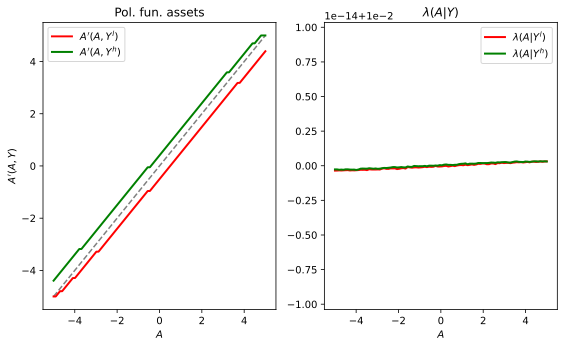

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(A, A, color='black', alpha=0.5, linestyle='dashed')
ax[0].plot(A, pf_a[:, 0], color='red', linewidth=2, label="$A'(A, Y^l)$")
ax[0].plot(A, pf_a[:, 1], color='green', linewidth=2, label="$A'(A, Y^h)$")
ax[0].legend()
ax[0].set_title('Pol. fun. assets')
ax[0].set_xlabel('$A$')
ax[0].set_ylabel("$A'(A, Y)$")
ax[1].plot(A, dist_if_y_lo, color='red', linewidth=2, label='$\lambda(A | Y^l)$')
ax[1].plot(A, dist_if_y_hi, color='green', linewidth=2, label='$\lambda(A | Y^h)$')
ax[1].legend()
ax[1].set_xlabel('$A$')
ax[1].set_title('$\lambda(A | Y)$')
plt.tight_layout()
plt.show()

The last plot on the right makes it look like some probabilities on the endogenous distribution are negative. They are not. The $y$-axis has been automatically scaled-and-shifted by `1e-14+1e-2`, which means that each tick label $i$ on the vertical axis are $i \times 10^{-14} + 1 \times 10^{-2}$. Therefore, the zero displayed is actually $0.01$. The label $-1$ actually is $0.01 - 10^{-14} > 0$. Moreover, you can verify that 

\begin{align*}
    \sum_{a \in A} \lambda(A = a | Y = y) &= 1 & \forall\ y \in Y \\
    \sum_{a \in A} \sum_{y \in Y} \lambda(A = a, Y = y) &= 1
\end{align*}

by simply running `dist_if_y_lo.sum()`, `dist_if_y_hi.sum()` and `ergo_dist.sum().sum()`.

Now, the endogenous distribution looks rather uninteresting. This is because we have chosen:

- Only two values of income, $Y^l$ and $Y^h$;
- The ergodic probability of each income level is exactly $0.5$; and
- The grid of asset holdings is centered around zero.

In a more general version of this model, where we allow for a general AR(1) process for the endowment level $Y_t$, the ergodic distribution will be more interesting to look at. Moreover, a more credible calibration (especially on the borrowing constraint $\underline{A}$, i.e., `a_min`) will yield a skewed distribution of agents, which can match the wealth distribution we may observe in the data. Such improvements will make this model replicate the paper by [Huggett (1993)](https://www.sciencedirect.com/science/article/abs/pii/016518899390024M).